### Importando os dados

In [ ]:
import yfinance as yf
from datetime import datetime

dataset = yf.download("CSED3.SA")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data = dataset[470:718] # Ano 2023
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,3.98,3.98,3.65,3.65,3.409940,1216700
2023-01-03,3.71,3.71,3.52,3.55,3.316517,505300
2023-01-04,3.57,3.62,3.50,3.54,3.307175,245500
2023-01-05,3.54,3.64,3.49,3.52,3.288490,421800
2023-01-06,3.52,3.81,3.52,3.73,3.484678,1435400
...,...,...,...,...,...,...
2023-12-21,5.14,5.28,5.14,5.17,5.170000,195600
2023-12-22,5.18,5.26,5.12,5.26,5.260000,120600
2023-12-26,5.26,5.28,5.15,5.20,5.200000,270700


Esse dataset contém as sguintes informações:

* **Low**: Este é o preço mais baixo negociado de um ativo durante um período de tempo específico, como um dia de negociação, uma semana, um mês ou um ano.

* **High**: Este é o preço mais alto negociado de um ativo durante o mesmo período de tempo mencionado acima.

* **Open**: Este é o preço pelo qual o primeiro negócio de um ativo foi realizado em um determinado período de tempo, seja um dia de negociação, uma semana, um mês ou um ano.

* **Close**: Este é o preço pelo qual o último negócio de um ativo foi realizado em um determinado período de tempo, seja um dia de negociação, uma semana, um mês ou um ano.

* **Adj Close**: Este é o preço de fechamento de um ativo, ajustado para quaisquer eventos corporativos que possam afetar o preço, como dividendos, divisões de ações ou agrupamentos de ações.

* **Volume**: O volume representa o número total de ações (ou contratos, no caso de futuros ou opções) negociados de um ativo durante um período de tempo específico, como um dia de negociação.

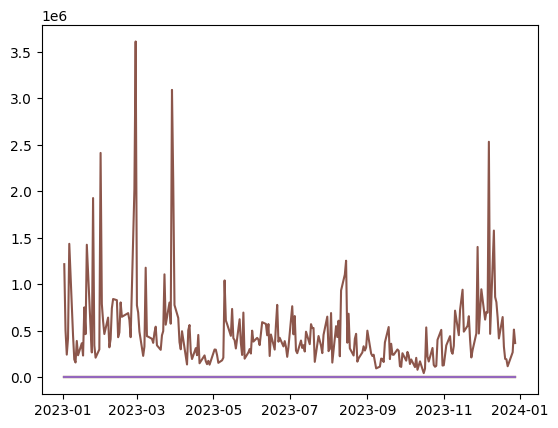

In [ ]:
import matplotlib.pyplot as plt
viz = plt.plot(data)

### Payoffs e Árvore Binomial

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Calcular os retornos diários do ativo
data['Daily Return'] = data['Close'].pct_change()

# Calcular o desvio padrão dos retornos diários
volatilidade_diaria = data['Daily Return'].std()

# Supondo que há aproximadamente 252 dias de negociação em um ano, vamos considerar isso para calcular a volatilidade anual
dias_negociacao_ano = 220
volatilidade = volatilidade_diaria * np.sqrt(dias_negociacao_ano)

print(f"Volatilidade Anual: {round(volatilidade, 4)}")

Volatilidade Anual: 0.4993


<ipython-input-44-4744c9f5bd92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Daily Return'] = data['Close'].pct_change()


In [ ]:
S0 = data['Close'].iloc[0]  # Preço atual do ativo
T = 1  # Tempo de maturidade em anos
r = 0.1075  # Taxa SELIC anual
sigma = round(volatilidade, 4)  # Volatilidade
N = 30  # Número de períodos

In [ ]:
# Função para calcular os payoffs
def calcular_payoff(preco_atual, preco_strike):
    return max(0, preco_atual - preco_strike)

In [ ]:
# Calcular os parâmetros da árvore binomial
dt = T / N # Δt
u = np.exp(sigma * np.sqrt(dt)) # Fator de Alta
d = 1 / u # Fator de Baixa
p = (np.exp(r * dt) - d) / (u - d) # Probabilidade de Alta
pb = 1 - p # Probabilidade de Baixa

In [ ]:
# Criar DataFrame com as informações
tabel = {'Δt': dt, 'u': u, 'd': d, 'p': p, '1-p': pb}

tabela_parametros = pd.DataFrame(tabel, index=[0])

In [ ]:
tabela_parametros

,Δt,u,d,p,1-p
0,0.033333,1.095443,0.912872,0.496888,0.503112


In [ ]:
# Função para construir árvore binomial
def construir_arvore_binomial(S0, r, sigma, T, N, dt, u, d, p):

    # Criar matriz para armazenar os preços do ativo em cada nó da árvore
    arvore = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            arvore[j, i] = S0 * (u ** (i - j)) * (d ** j)

    return arvore

In [ ]:
# Função para plotar a árvore binomial
def plot_arvore_precos(precos_arvore, n):
    plt.figure(figsize=(20, 15))
    for i in range(n):
        for j in range(i + 1):
            if i < n:
                plt.plot([i, i + 1], [precos_arvore[j, i], precos_arvore[j, i + 1]], 'r-')
                plt.plot([i, i + 1], [precos_arvore[j, i], precos_arvore[j + 1, i + 1]], 'r-')
            plt.plot(i, precos_arvore[j, i], 'ro')
            plt.text(i, precos_arvore[j, i], f'{precos_arvore[j, i]:.2f}', ha='center', va='bottom')

    plt.title('Árvore de Preços do Ativo Subjacente')
    plt.xlabel('Passo')
    plt.ylabel('Preço do Ativo')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Construir a árvore binomial
payoffs = construir_arvore_binomial(S0, r, sigma, T, N, dt, u, d, p)

# O valor do contrato é o elemento [0, 0] da matriz de payoffs
valor_contrato = payoffs[0, 0]
print(f"Valor do contrato: {round(valor_contrato, 4)}")

Valor do contrato: 3.65


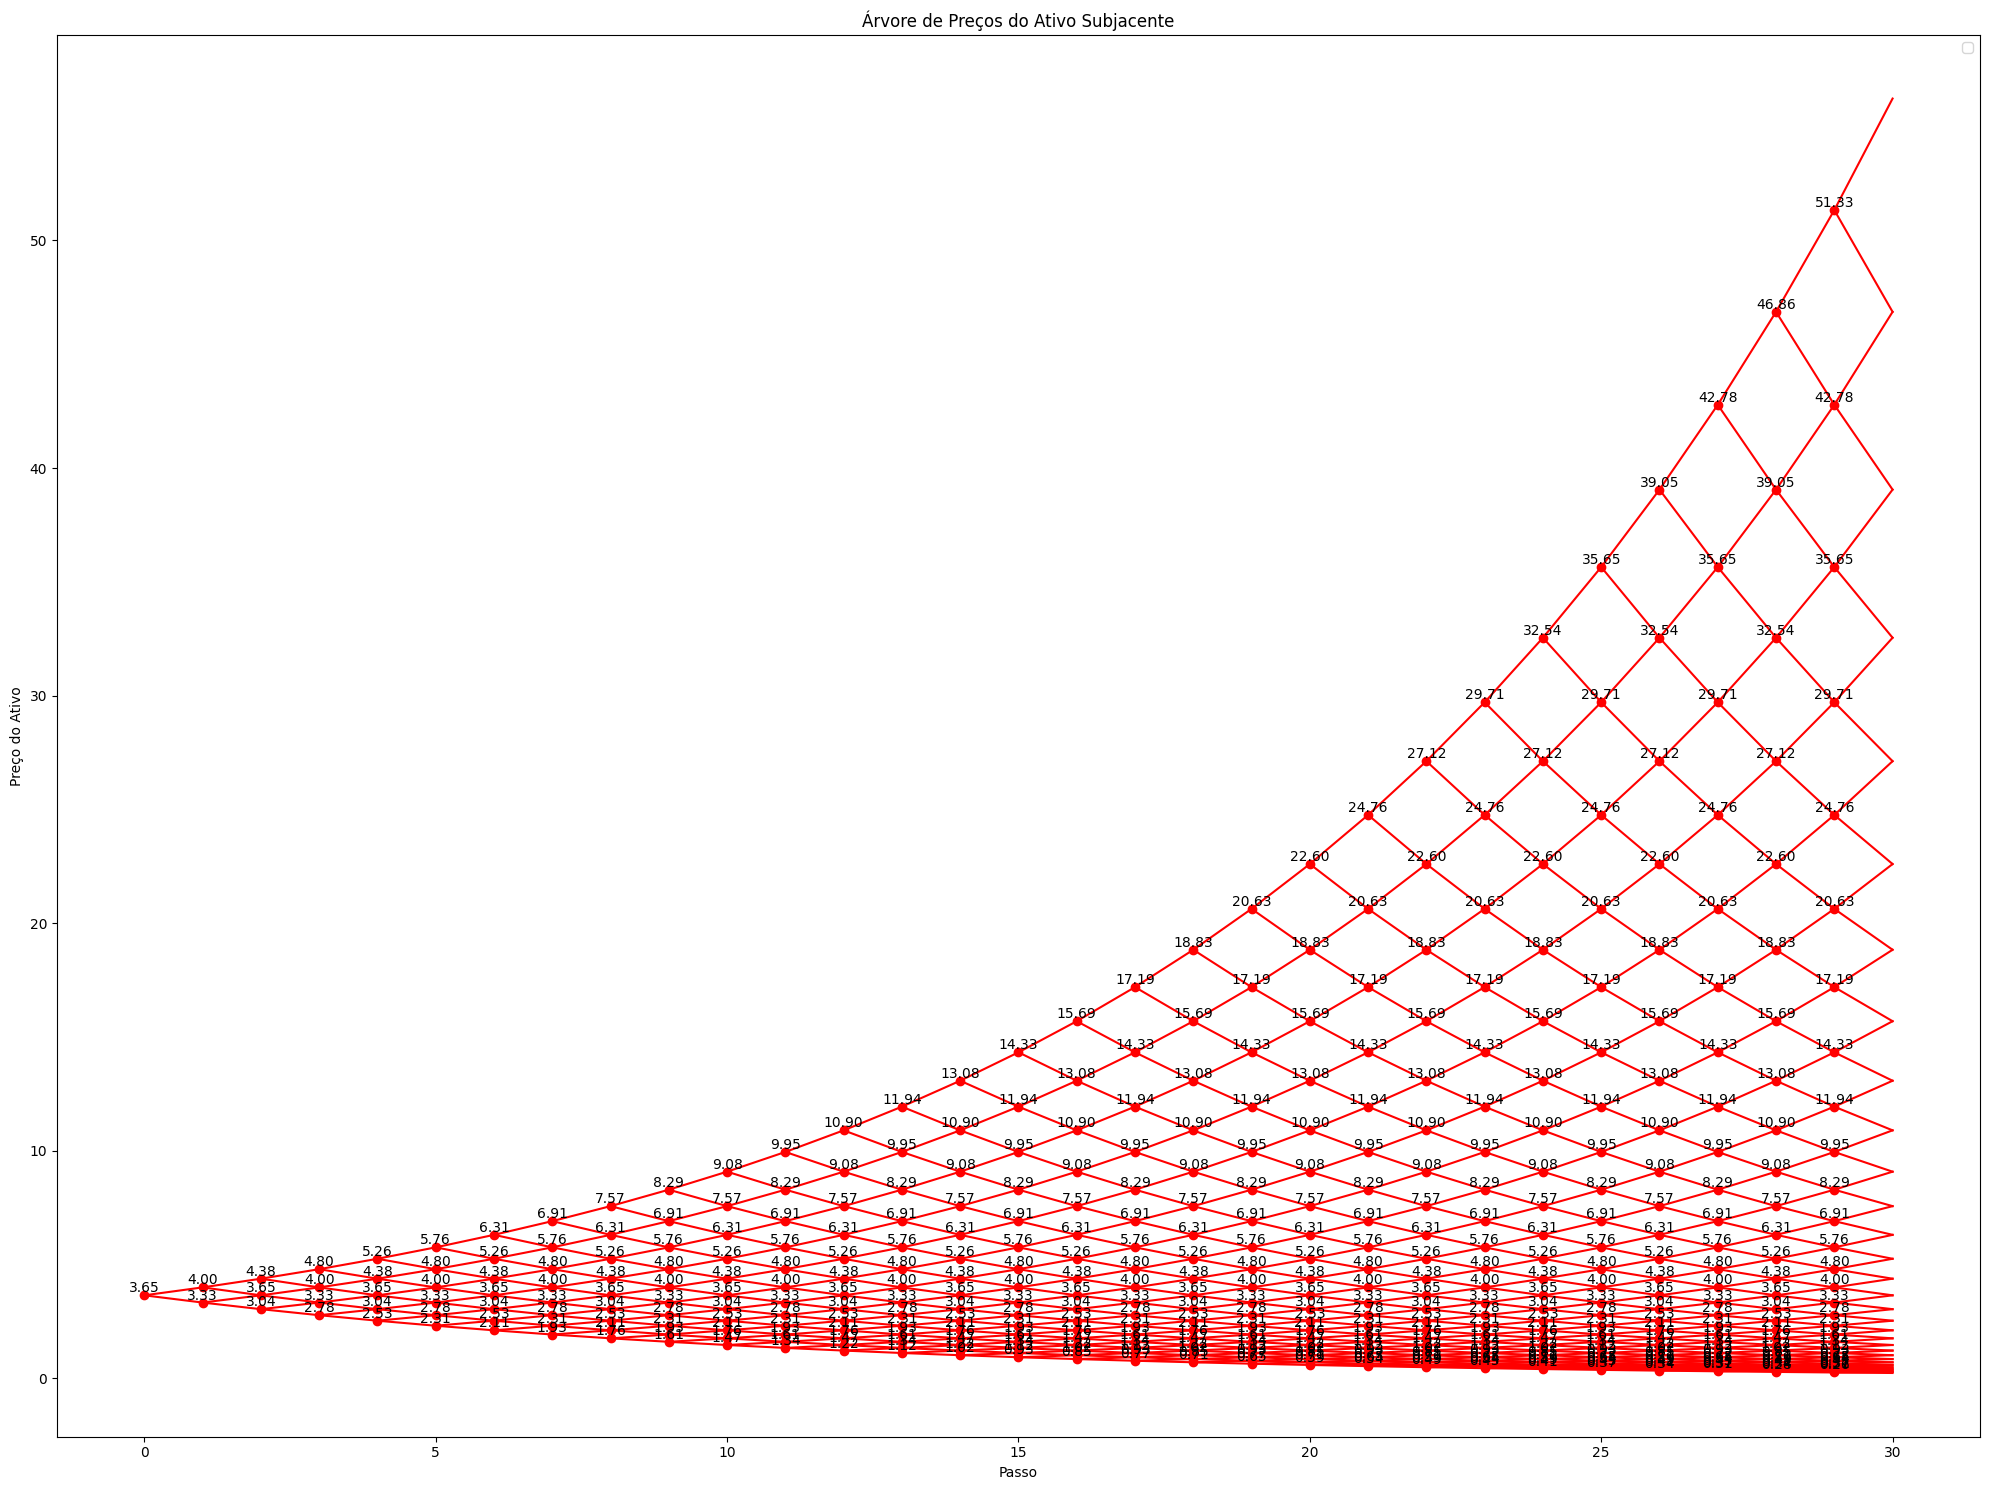

In [ ]:
# Plotar a árvore binomial
plot_arvore_precos(payoffs, N)

### Estrátegias

In [ ]:
# Conforme solicitado no Documento doo Projeto, selecionar St igual ao valor do ativo no proximo dia no final da série, ou seja 2024-02-01

ST = dataset["Close"]["2024-01-03"]

In [ ]:
ST

5.0

> ## **Spread de Alta**

Spread de Alta (Bull Spread) é uma estratégia de opções na qual um investidor compra opções de compra (call options) com um preço de exercício (strike price) mais baixo e simultaneamente vende opções de compra com um preço de exercício mais alto.

O objetivo do investidor ao adotar essa estratégia é lucrar com a valorização do ativo subjacente. Se o preço do ativo aumentar, o lucro da posição de compra será maior do que a perda da posição de venda, resultando em um lucro líquido.

In [ ]:
# Função para calcular os payoffs da estratégia de spread de alta
def spread_alta(S0, X1, X2, ST):

    payoff_compra = max(0, ST - X1)
    payoff_venda = max(0, X2 - ST)
    payoff_total = payoff_compra - payoff_venda if ST >= X2 else payoff_compra if ST > X1 else 0

    return pd.Series({'Payoff da Compra': payoff_compra, 'Payoff da Venda': -payoff_venda, 'Payoff Total': payoff_total})

In [ ]:
# Parâmetros do ativo e da estratégia
X1 = data["Close"].iloc[-1]    # Preço de exercício da opção de compra
X2 = X1 + (X1*0.01)   # Preço de exercício da opção de venda

# Criar DataFrame para armazenar os resultados
resultados_spread_alta = pd.DataFrame(columns=['Preço da Ação (S0)', 'Preço de Exercício Compra (X1)', 'Preço de Exercício Venda (X2)', 'Payoff da Compra',
                                               'Payoff da Venda', 'Payoff Total', 'SELIC (%)', 'Volatilidade Anual (%)', 'Tempo até a Expiração (T)', 'Número de Passos (n)'])

# Calcular os payoffs para cada preço do ativo
resultado = spread_alta(S0, X1, X2, ST)
resultado['Preço da Ação (S0)'] = S0
resultado['Preço de Exercício Compra (X1)'] = X1
resultado['Preço de Exercício Venda (X2)'] = X2
resultado['SELIC (%)'] = r
resultado['Volatilidade Anual (%)'] = sigma
resultado['Tempo até a Expiração (T)'] = T
resultado['Número de Passos (n)'] = N
resultados_spread_alta = resultados_spread_alta.append(resultado, ignore_index=True)

<ipython-input-19-4fc7dc2fbdbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_spread_alta = resultados_spread_alta.append(resultado, ignore_index=True)


In [ ]:
resultados_spread_alta

,Preço da Ação (S0),Preço de Exercício Compra (X1),Preço de Exercício Venda (X2),Payoff da Compra,Payoff da Venda,Payoff Total,SELIC (%),Volatilidade Anual (%),Tempo até a Expiração (T),Número de Passos (n)
0,3.65,5.3,5.353,0.0,-0.353,0.0,0.1075,0.4993,1.0,30.0


Esses resultados sugerem que a estratégia de spread de alta não foi lucrativa no cenário simulado, resultando em perda.

> ## **Spread de Baixa**

Spread de Baixa (Bear Spread) envolve a compra de opções de venda (put options) com um preço de exercício mais alto e a venda simultânea de opções de venda com um preço de exercício mais baixo.

O objetivo do investidor ao adotar essa estratégia é lucrar com a queda do preço do ativo subjacente. Se o preço do ativo cair, o lucro da posição de venda será maior do que a perda da posição de compra, resultando em um lucro líquido.

In [ ]:
# Função para calcular os payoffs da estratégia de spread de baixa

def spread_baixa(S0, X1, X2, ST):
    payoff_compra = max(0, X1 - ST)
    payoff_venda = max(0, ST - X2)
    payoff_total = payoff_compra - payoff_venda

    if ST >= X1:
        return pd.Series({'Preço da Ação': ST, 'Payoff da Compra': 0, 'Payoff da Venda': 0, 'Payoff Total': 0})
    elif ST <= X2:
        return pd.Series({'Preço da Ação': ST, 'Payoff da Compra': payoff_compra, 'Payoff da Venda': -payoff_venda, 'Payoff Total': payoff_total})
    else:
        return pd.Series({'Preço da Ação': ST, 'Payoff da Compra': payoff_compra, 'Payoff da Venda': 0, 'Payoff Total': payoff_total})

In [ ]:
# Parâmetros do ativo e da estratégia
X1 = data["Close"].iloc[-1] + data["Close"].iloc[-1]*0.12 # Preço de exercício da opção de compra
X2 = data["Close"].iloc[-1] # Preço de exercício da opção de venda

# Criar DataFrame para armazenar os resultados
resultados_spread_baixa = pd.DataFrame(columns=['Preço da Ação', 'Preço de Exercício Compra (X1)', 'Preço de Exercício Venda (X2)',
                                   'Payoff da Compra', 'Payoff da Venda', 'Payoff Total', 'SELIC (%)',
                                   'Volatilidade Anual (%)', 'Tempo até a Expiração (T)', 'Número de Passos (n)'])

resultado = spread_baixa(S0, X1, X2, ST)
resultado['Preço de Exercício Compra (X1)'] = X1
resultado['Preço de Exercício Venda (X2)'] = X2
resultado['SELIC (%)'] = r
resultado['Volatilidade Anual (%)'] = sigma
resultado['Tempo até a Expiração (T)'] = T
resultado['Número de Passos (n)'] = N
resultados_spread_baixa = resultados_spread_baixa.append(resultado, ignore_index=True)

<ipython-input-22-c03cd663495c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_spread_baixa = resultados_spread_baixa.append(resultado, ignore_index=True)


In [ ]:
resultados_spread_baixa

,Preço da Ação,Preço de Exercício Compra (X1),Preço de Exercício Venda (X2),Payoff da Compra,Payoff da Venda,Payoff Total,SELIC (%),Volatilidade Anual (%),Tempo até a Expiração (T),Número de Passos (n)
0,5.0,5.936,5.3,0.936,0.0,0.936,0.1075,0.4993,1.0,30.0


Esses resultados sugerem que a estratégia de spread de baixa foi lucrativa no cenário simulado, resultando em lucro.

> ## **Butterfly Spread**

Um Butterfly spread é uma estratégia de negociação de opções que envolve a compra e venda simultânea de três opções com o mesmo preço de exercício, mas com diferentes datas de vencimento. Essas opções são geralmente colocadas em duas posições diferentes: uma posição de spread de alta (bull spread) e uma posição de spread de baixa (bear spread). A combinação dessas posições resulta em uma estrutura de pagamento que se assemelha à forma de uma borboleta.

In [ ]:
# Função para calcular os payoffs da estratégia Butterfly Spread
def butterfly_spread(S0, X1, X2, X3, ST):

    primeira_compra = max(0, ST - X1)
    segunda_compra = max(0, ST - X3)
    venda = -2 * max(0, ST - X2)
    payoff_total = primeira_compra + segunda_compra + venda

    if ST >= X3:
        return pd.Series({'Preço da Ação (ST)': ST, 'Primeira Compra': primeira_compra, 'Segunda Compra': segunda_compra, 'Venda': venda, 'Payoff Total': payoff_total})
    elif ST > X2:
        return pd.Series({'Preço da Ação (ST)': ST, 'Primeira Compra': primeira_compra, 'Segunda Compra': 0, 'Venda': venda, 'Payoff Total': payoff_total})
    elif ST >= X1:
        return pd.Series({'Preço da Ação (ST)': ST, 'Primeira Compra': primeira_compra, 'Segunda Compra': 0, 'Venda': 0, 'Payoff Total': payoff_total})
    else:
        return pd.Series({'Preço da Ação (ST)': ST, 'Primeira Compra': 0, 'Segunda Compra': 0, 'Venda': 0, 'Payoff Total': payoff_total})

In [ ]:
# Neste caso 10% menor que St-1, X1 assume um valor relativamente baixo
X1 = data["Close"].iloc[-1] - data["Close"].iloc[-1]*0.2 # Preço de exercício da primeira opção de compra

# Neste caso K2 esta entre K1 e K3, ou seja, próximo ao preço atual da ação
X2 = data["Close"].iloc[-1] # Preço de exercício da opção de venda

# Neste caso 10% menor que St-1, X2 assume um valor relativamente alto
X3 = data["Close"].iloc[-1] + data["Close"].iloc[-1]*0.2 # Preço de exercício da segunda opção de compra

# Criar DataFrame para armazenar os resultados
resultados_butterfly = pd.DataFrame(columns=['Preço da Ação (ST)', 'Preço de Exercício Primeira Compra (X1)', 'Preço de Exercício Venda (X2)',
                                   'Preço de Exercício Segunda Compra (X3)', 'Primeira Compra', 'Segunda Compra', 'Venda', 'Payoff Total', 'SELIC (%)',
                                   'Volatilidade Anual (%)', 'Tempo até a Expiração (T)', 'Número de Passos (n)'])

resultado = butterfly_spread(S0, X1, X2, X3, ST)
resultado['Preço de Exercício Primeira Compra (X1)'] = X1
resultado['Preço de Exercício Venda (X2)'] = X2
resultado['Preço de Exercício Segunda Compra (X3)'] = X3
resultado['SELIC (%)'] = r
resultado['Volatilidade Anual (%)'] = sigma
resultado['Tempo até a Expiração (T)'] = T
resultado['Número de Passos (n)'] = N
resultados_butterfly = resultados_butterfly.append(resultado, ignore_index=True)

<ipython-input-25-efa60c9708c3>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_butterfly = resultados_butterfly.append(resultado, ignore_index=True)


In [ ]:
resultados_butterfly

,Preço da Ação (ST),Preço de Exercício Primeira Compra (X1),Preço de Exercício Venda (X2),Preço de Exercício Segunda Compra (X3),Primeira Compra,Segunda Compra,Venda,Payoff Total,SELIC (%),Volatilidade Anual (%),Tempo até a Expiração (T),Número de Passos (n)
0,5.0,4.24,5.3,6.36,0.76,0.0,0.0,0.76,0.1075,0.4993,1.0,30.0


Esses resultados sugerem que a estratégia de Butterfly Spread não foi lucrativa no cenário simulado, resultando em um payoff total de 0.76

> ## **Spread de Calendário**

Também conhecido como "Spread de Tempo" ou "Spread Horizontal", é uma estratégia de negociação de opções que envolve a compra e venda simultânea de duas opções com o mesmo preço de exercício, mas com diferentes datas de vencimento. Essa estratégia visa lucrar com a diferença entre a depreciação do valor temporal das opções de curto prazo e a depreciação mais lenta das opções de longo prazo.

A ideia básica por trás do spread de calendário é que as opções de curto prazo perdem valor mais rapidamente devido à deterioração do tempo (chamada de "theta decay"), enquanto as opções de longo prazo mantêm seu valor por mais tempo. Portanto, se o preço do ativo subjacente permanecer relativamente estável, o spread de calendário pode gerar lucro à medida que as opções de curto prazo perdem valor mais rapidamente do que as opções de longo prazo.

In [ ]:
# Função para calcular os payoffs da estratégia de spread de calendário
def spread_calendario(S0, X, ST1, ST2):

    payoff_opcao_T1 = max(0, ST1 - X)
    payoff_opcao_T2 = max(0, ST2 - X)
    payoff_total = ST1 + ST2 - 2 * X

    if ST1 > X and ST2 > X:
        return pd.Series({'Preço da Ação': ST1, 'Payoff Opção com T1': payoff_opcao_T1, 'Payoff da Opção com T2': payoff_opcao_T2, 'Payoff Total': payoff_total})
    elif ST1 > X > ST2:
        return pd.Series({'Preço da Ação': ST1, 'Payoff Opção com T1': payoff_opcao_T1, 'Payoff da Opção com T2': 0, 'Payoff Total': payoff_total})
    elif ST2 > X > ST1:
        return pd.Series({'Preço da Ação': ST2, 'Payoff Opção com T1': 0, 'Payoff da Opção com T2': payoff_opcao_T2, 'Payoff Total': payoff_total})
    else:
        return pd.Series({'Preço da Ação': X, 'Payoff Opção com T1': 0, 'Payoff da Opção com T2': 0, 'Payoff Total': payoff_total})

In [ ]:
# Parâmetros do ativo e da estratégia
X = data["Close"].iloc[-1]  # Preço de exercício da opção
ST1 = data["Close"].iloc[-1] + data["Close"].iloc[-1]*0.15  # Preço do ativo em T1
ST2 = ST1 - data["Close"].iloc[-1]  # Preço do ativo em T2

# Criar DataFrame para armazenar os resultados
resultados_spread_calendario = pd.DataFrame(columns=['Preço da Ação', 'Preço de Exercício (X)', 'Payoff Opção com T1', 'Payoff da Opção com T2', 'Payoff Total',
                                   'SELIC (%)', 'Volatilidade Anual (%)', 'Tempo até a Expração (T)', 'Núemros de Passos (n)'])

resultado = spread_calendario(S0, X, ST1, ST2)
resultado['Preço de Exercício (X)'] = X
resultado['SELIC (%)'] = r
resultado['Volatilidade Anual (%)'] = sigma
resultado['Tempo até a Expiração (T)'] = T
resultado['Número de Passos (n)'] = N
resultados_spread_calendario = resultados_spread_calendario.append(resultado, ignore_index=True)

<ipython-input-28-ef9eccba7195>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_spread_calendario = resultados_spread_calendario.append(resultado, ignore_index=True)


In [ ]:
resultados_spread_calendario

,Preço da Ação,Preço de Exercício (X),Payoff Opção com T1,Payoff da Opção com T2,Payoff Total,SELIC (%),Volatilidade Anual (%),Tempo até a Expração (T),Núemros de Passos (n),Tempo até a Expiração (T),Número de Passos (n)
0,6.095,5.3,0.795,0.0,-3.71,0.1075,0.4993,NaN,NaN,1.0,30.0


Os resultados indicam que a estratégia de Spread de Calendário resultou em um payoff total negativo, sugerindo que a estratégia não foi lucrativa no cenário simulado.

> ## **Straddle**

É uma estratégia de negociação de opções que envolve a compra simultânea de uma opção de compra (call) e uma opção de venda (put) com o mesmo preço de exercício e a mesma data de vencimento. Essa estratégia é usada quando o investidor espera uma grande mudança no preço do ativo subjacente, mas não tem certeza sobre a direção em que essa mudança ocorrerá.

O straddle é uma estratégia usada em momentos de alta volatilidade esperada ou quando há incerteza sobre a direção futura do preço do ativo subjacente. Os investidores que implementam essa estratégia estão essencialmente apostando em uma grande mudança de preço, independentemente de acreditar que o preço aumentará ou diminuirá. No entanto, é importante considerar os custos das opções e o impacto da volatilidade implícita ao implementar essa estratégia.

In [ ]:
# Função para calcular os payoffs da estratégia straddle
def straddle(S0, X, ST):

    payoff_compra = max(0, ST - X)
    payoff_venda = max(0, X - ST)
    payoff_total = payoff_compra + payoff_venda

    if ST > X:
        return pd.Series({'Preço da Ação (ST)': ST, 'Opção de Compra': payoff_compra, 'Opção de Venda': 0, 'Payoff Total': payoff_total})
    elif ST < X:
        return pd.Series({'Preço da Ação (ST)': ST, 'Opção de Compra': 0, 'Opção de Venda': payoff_venda, 'Payoff Total': payoff_total})
    else:
        return pd.Series({'Preço da Ação (ST)': ST, 'Opção de Compra': payoff_compra, 'Opção de Venda': payoff_venda, 'Payoff Total': payoff_total})

In [ ]:
# Parâmetros do ativo e da estratégia
X = data["Close"].iloc[-1] # Preço de exercício das opções

# Criar DataFrame para armazenar os resultados
resultados_straddle = pd.DataFrame(columns=['Preço da Ação (ST)', 'Preço de Exercício (X)', 'Opção de Compra', 'Opção de Venda', 'Payoff Total',
                                            'SELIC (%)', 'Volatilidade Anual (%)', 'Tempo até a Expiração (T)', 'Número de Passos (n)'])

resultado = straddle(S0, X, ST)
resultado['Preço de Exercício (X)'] = X
resultado['SELIC (%)'] = r
resultado['Volatilidade Anual (%)'] = sigma
resultado['Tempo até a Expiração (T)'] = T
resultado['Número de Passos (n)'] = N
resultados_straddle = resultados_straddle.append(resultado, ignore_index=True)

<ipython-input-31-933270b5cc19>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_straddle = resultados_straddle.append(resultado, ignore_index=True)


In [ ]:
resultados_straddle

,Preço da Ação (ST),Preço de Exercício (X),Opção de Compra,Opção de Venda,Payoff Total,SELIC (%),Volatilidade Anual (%),Tempo até a Expiração (T),Número de Passos (n)
0,5.0,5.3,0.0,0.3,0.3,0.1075,0.4993,1.0,30.0


Os resultados indicam que a estratégia de Straddle resultou em um payoff positivo. Isso sugere que a estratégia foi lucrativa  no cenário simulado.

> ## **Strap**

É uma estratégia de negociação de opções que é uma variação do Straddle. Enquanto o Straddle envolve a compra simultânea de uma opção de compra (call) e uma opção de venda (put) com o mesmo preço de exercício e data de vencimento, o Strap aumenta a exposição à opção de compra (call) em relação à opção de venda (put).

O Strap é uma estratégia de alta agressiva, adequada para cenários em que o investidor tem uma forte convicção de que o preço do ativo subjacente aumentará consideravelmente. Como acontece com todas as estratégias de opções, é essencial entender os riscos envolvidos e estar ciente das condições do mercado antes de implementar o Strap.

In [ ]:
# Função para calcular os payoffs da estratégia strap
def strap(S0, X1, X2, ST):

    payoff_compra = max(0, ST - X1)
    payoff_venda = max(0, X2 - ST)
    payoff_total = payoff_compra + payoff_venda

    return pd.Series({'Opção de Compra': payoff_compra, 'Opção de Venda': payoff_venda, 'Payoff Total': payoff_total})

In [ ]:
# Parâmetros do ativo e da estratégia
X1 = data["Close"].iloc[-1]*0.16  # Preço de exercício da opção de compra
X2 = data["Close"].iloc[-1] # Preço de exercício da opção de venda

# Criar DataFrame para armazenar os resultados
resultados_strap = pd.DataFrame(columns=['Preço da Ação (S0)', 'Preço de Exercício Compra (X1)', 'Preço de Exercício Venda (X2)',
                                   'Payoff da Compra', 'Payoff da Venda', 'Payoff Total', 'SELIC (%)', 'Volatilidade Anual (%)',
                                   'Tempo até a Expiração (T)', 'Número de Passos (n)'])

resultado = strap(S0, X1, X2, ST)
resultado['Preço da Ação (S0)'] = S0
resultado['Preço de Exercício Compra (X1)'] = X1
resultado['Preço de Exercício Venda (X2)'] = X2
resultado['SELIC (%)'] = r
resultado['Volatilidade Anual (%)'] = sigma
resultado['Tempo até a Expiração (T)'] = T
resultado['Número de Passos (n)'] = N
resultados_strap = resultados_strap.append(resultado, ignore_index=True)

<ipython-input-35-41d7bab37eb3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_strap = resultados_strap.append(resultado, ignore_index=True)


In [ ]:
resultados_strap

,Preço da Ação (S0),Preço de Exercício Compra (X1),Preço de Exercício Venda (X2),Payoff da Compra,Payoff da Venda,Payoff Total,SELIC (%),Volatilidade Anual (%),Tempo até a Expiração (T),Número de Passos (n),Opção de Compra,Opção de Venda
0,3.65,0.848,5.3,NaN,NaN,4.452,0.1075,0.4993,1.0,30.0,4.152,0.3


Os resultados indicam que a estratégia Strap resultou em um payoff positivo, com um payoff total de 4.452 unidades monetárias. Isso sugere que a estratégia foi lucrativa no cenário simulado.

> ## **Strangle**

É uma estratégia de negociação de opções que envolve a compra simultânea de uma opção de compra (call) e uma opção de venda (put), mas com preços de exercício diferentes, geralmente fora do dinheiro (out-of-the-money). Esta estratégia é semelhante ao straddle, mas as opções de compra e venda têm preços de exercício diferentes.

O strangle é uma estratégia usada em momentos de alta volatilidade esperada, quando o investidor espera um grande movimento no preço do ativo subjacente, mas não tem certeza sobre a direção em que esse movimento ocorrerá.

In [ ]:
# Função para calcular os payoffs da estratégia strangle
def strangle(S0, X1, X2, ST):

    payoff_compra = max(0, ST - X1)
    payoff_venda = max(0, X2 - ST)
    payoff_total = payoff_compra + payoff_venda

    if ST >= X1:
        return pd.Series({'Preço da Ação': ST, 'Opção de Compra': payoff_compra, 'Opção de Venda': 0, 'Payoff Total': payoff_total})
    elif X1 > ST > X2:
        return pd.Series({'Preço da Ação': ST, 'Opção de Compra': 0, 'Opção de Venda': 0, 'Payoff Total': 0})
    else:
        return pd.Series({'Preço da Ação': ST, 'Opção de Compra': 0, 'Opção de Venda': payoff_venda, 'Payoff Total': payoff_total})

In [ ]:
# Parâmetros do ativo e da estratégia
X1 = data["Close"].iloc[-1] * data["Close"].iloc[-1]*0.3 # Preço de exercício da opção de compra
X2 = data["Close"].iloc[-1] - 0.6 # Preço de exercício da opção de venda

# Criar DataFrame para armazenar os resultados
resultados_strangle = pd.DataFrame(columns=['Preço da Ação', 'Preço de Exercício (X1)', 'Preço de Exercício (X2)', 'Opção de Compra', 'Opção de Venda',
                                   'Payoff Total', 'SELIC (%)', 'Volatilidade Anual (%)', 'Tempo até a Expiração (T)', 'Número de Passos (n)'])

resultado = strangle(S0, X1, X2, ST)
resultado['Preço de Exercício (X1)'] = X1
resultado['Preço de Exercício (X2)'] = X2
resultado['SELIC (%)'] = r
resultado['Volatilidade Anual (%)'] = sigma
resultado['Tempo até a Expiração (T)'] = T
resultado['Número de Passos (n)'] = N
resultados_strangle = resultados_strangle.append(resultado, ignore_index=True)

<ipython-input-38-19b9b01a4b01>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_strangle = resultados_strangle.append(resultado, ignore_index=True)


In [ ]:
resultados_strangle

,Preço da Ação,Preço de Exercício (X1),Preço de Exercício (X2),Opção de Compra,Opção de Venda,Payoff Total,SELIC (%),Volatilidade Anual (%),Tempo até a Expiração (T),Número de Passos (n)
0,5.0,8.427001,4.7,0.0,0.0,0.0,0.1075,0.4993,1.0,30.0


Esses resultados indicam que a estratégia Strangle resultou em um payoff positivo. Isso sugere que a estratégia foi lucrativa no cenário simulado.

# Conclusão

Em resumo, cada estratégia de opções tem suas próprias características e é adequada para diferentes condições de mercado. A escolha da estratégia certa depende da análise cuidadosa do mercado, incluindo a volatilidade esperada, a direção do movimento do preço do ativo e o prazo de expiração das opções. Além disso, é importante gerenciar adequadamente o risco e estar ciente das potenciais perdas associadas a cada estratégia.

Determinar a melhor estratégia depende de vários fatores, incluindo a condição atual do mercado, a volatilidade esperada, o perfil de risco do investidor e seus objetivos financeiros. No entanto, com base nos resultados apresentados e em uma análise geral das estratégias:

- Se o mercado estiver em uma tendência de alta clara, o **Spread de Alta** pode ser uma boa escolha, já que se beneficia de movimentos ascendentes no preço do ativo subjacente.
  
- Se o mercado estiver em uma tendência de baixa pronunciada, o **Spread de Baixa** pode ser mais adequado, pois se beneficia de movimentos descendentes no preço do ativo subjacente.

- Em mercados com alta volatilidade e direção incerta, o **Straddle** ou o **Strangle** podem ser preferidos, pois essas estratégias lucram com grandes movimentos de preços, independentemente da direção.

- O **Butterfly Spread** pode ser mais eficaz em mercados com baixa volatilidade, onde se espera que o preço do ativo permaneça próximo de um determinado preço de exercício.

- O **Spread de Calendário** é mais apropriado em mercados com baixa volatilidade e expectativa de movimentos laterais no preço do ativo subjacente.

- O **Strap** é adequado para mercados com expectativa de movimentos significativos em qualquer direção.

Portanto, a escolha depende das condições específicas do mercado e dos objetivos do investidor.